In [1]:
import numpy as np
from itertools import product
import itertools
import re
import random
import math

## ZAD1

In [2]:
signs = ['.', '(', ')', ';', '"', '[', ']', ',', '?', '!', ':', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
polish = [('ź', 'z'), ('ż', 'z'), ('ą', 'a'), ('ę', 'e'), ('ó', 'o'), ('ł', 'l'), ('ć', 'c'), ('ń', 'n'), ('ś', 's')]

def tokenize(line):
    line2 = []
    line = line.split(' ')
    for base in line:
        base = base.lower()
        for sign in signs:
            base = base.replace(sign, ' ')
        base = base.strip()
        base = base.split(' ')
        if base != '' and base != ['']:
            line2.extend(base)
    return line2

def remove_polish(line):
    line2 = []
    for word in line:
        for sign in polish:
            word = word.replace(sign[0], sign[1])
        line2.append(word)
    return line2

def load_set(file='../train data/task3_train.txt', k=10000):
    i = 0
    lines = []
    with open(file, 'r', encoding='utf8') as base_vectors_lines:
        for line in base_vectors_lines:
            if i == k:
                break
            lines.append(tokenize(line))
            i += 1

    return lines

def tokenize(line):
    line2 = []
    line = line.split(' ')
    for base in line:
        base = base.lower()
        for sign in signs:
            base = base.replace(sign, ' ')
        base = base.strip()
        base = base.split(' ')
        if base != '' and base != ['']:
            line2.extend(base)

    return line2

def tokenize_big(line):
    line2 = []
    line = line.split(' ')
    for base in line:
        for sign in signs:
            base = base.replace(sign, ' ')
        base = base.strip()
        base = base.split(' ')
        if base != '' and base != ['']:
            line2.extend(base)

    return line2

def remove_polish(line):
    line2 = []
    for word in line:
        for sign in polish:
            word = word.replace(sign[0], sign[1])
        line2.append(word)
    return line2

def load_big_set(file='../train data/task3_train.txt', k=10000):
    i = 0
    lines = []
    with open(file, 'r', encoding='utf8') as base_vectors_lines:
        for line in base_vectors_lines:
            if i == k:
                break
            lines.append(tokenize_big(line))
            i += 1

    return lines

def load_2grams(file='../train data/2grams', k=5):
    dictionary = {}
    i = 0
    with open(file, 'r', encoding='utf8') as base_vectors_lines:
        for line in base_vectors_lines:
            line = line.strip().lower()
            line = line.split(' ')
            if int(line[0]) >= k:
                if line[1] not in dictionary:
                    dictionary[line[1]] = {}
                dictionary[line[1]][line[2]] = int(line[0])
            else:
                break
            i += 1

    return dictionary

def score(phrase1, phrase2):
    s = 0
    for i in range(len(phrase1)):
        if phrase1[i] == phrase2[i]:
            s += 1

    return s/len(phrase1)

def create_dgrams(training_set, casts):
    dgrams = {}
    for line in training_set:
        if len(line) >= 2:
            fst = line[0]
            for word in line[1:]:
                snd = word
                if not wrong([fst, snd], casts):
                    if fst not in dgrams:
                        dgrams[fst] = {}
                    if snd not in dgrams[fst]:
                        dgrams[fst][snd] = 0
                    dgrams[fst][snd] += 1
                fst = snd
    
    return dgrams

In [3]:
def fix_polish2(phrase, casts, digrams1, digrams2):
    perms = []
    i = 0
    for line in windows(phrase, k=2):
        perms.append([])
        best_perm = None
        bsc = -1
        for perm in permute(line, casts):
            pres = 0
            size = 1
            if perm[0] in digrams1:
                if perm[1] in digrams1[perm[0]]:
                    pres += digrams1[perm[0]][perm[1]]
                size += digrams1[perm[1]][0]
            if perm[0] in digrams2:
                if perm[1] in digrams2[perm[0]]:
                    pres += digrams2[perm[0]][perm[1]]
                size += digrams2[perm[1]][0]
            score = (pres/size) * math.log(size)
            perms[i].append((perm,score))
        i += 1
    
    output = []
    prev = None
    for i in range(len(perms)):
        mx = -1
        mperm = None
        for perm, sc in perms[i]:
            if perm[0] == prev:
                if sc > mx:
                    mx = sc
                    mperm = perm
        output.append(mperm[1])
        prev = mperm[1]           
    
    return output

def fix_case(phrase, bigs1, bigs2):
    ww = phrase[0]
    fixed = []
    fixed.append(ww.capitalize())
    if len(phrase) >= 2:
        for word in phrase[1:]:
            if word in bigs1 and (word not in bigs2 or (word in bigs2 and bigs2[word][1] / bigs2[word][2] >= 0.5)):
                fixed.append(bigs1[word])
            else:
                if word in bigs2 and bigs2[word][1] / bigs2[word][2] > 0.5:
                    fixed.append(bigs2[word][0])
                else:
                    fixed.append(word)
    
    return fixed

def create_casts(base_poli):
    dictionary = {}
    for key in base_poli:
        weak_key = remove_polish([key])[0]
        if weak_key not in dictionary:
            dictionary[weak_key] = []
        dictionary[weak_key].append(key)

    return dictionary

def load_polimorph(file='../train data/polimorfologik-2.1.txt'):
    dictionary = {}
    with open(file, 'r', encoding='utf8') as base_file:
        for line in base_file:
            line = line.strip().lower()
            line = line.split(";")
            line[2] = line[2].split("+")
            nl = []
            for comp in line[2]:
                spl = comp.split(":")
                if spl[0] != "subst":
                    if spl[0] not in nl:
                        nl.append(spl[0])
                else:
                    if spl[0] + ":" + spl[2] not in nl:
                        nl.append(spl[0] + ":" + spl[2])
            line[2] = nl
            dictionary[line[1]] = (line[0], line[2])

    return dictionary

def wrong(line, casts):
    if line not in permute(line, casts):
        return True
    return False

def flatten(listt):
        a = []
        for itemm in listt:
            if isinstance(itemm, list):
                a += flatten(itemm)
            else:
                a.append(itemm)
        return a

def combine(lines):
    conc = lines[0]
    if len(lines) == 1:
        conc = [conc]
    for part in lines[1:]:
        conc = list(map(list, itertools.product(conc, part)))
    conc2 = []
    for item in conc:
        conc2.append(flatten(item))
    return conc2

def permute(line, casts):
    line2 = []
    for word in line:
        if word in casts:
            line2.append(casts[word])
        else:
            line2.append([word])

    return combine(line2)

def windows(line, k=3):
    
    line2 = []
    line2.append(None)
    line2 += line
    line2.append(None)
    line = line2
    
    if len(line) < k:
        line2 = []
        for i in range(math.ceil((k-len(line))/2)):
            line2.append(None)
        line2 += line
        for i in range(math.floor((k-len(line))/2)):
            line2.append(None)
        line = line2
        
    if len(line) == k:
        return [line]
    
    else:
        lines = []
        line2 = line[0:k]
        lines.append(line2.copy())
        for word in line[k:]:
            del line2[0]
            line2.append(word)
            lines.append(line2.copy())
        return lines
    
def count_digrams(digrams):
    for fst in digrams:
        count = 0
        for snd in digrams[fst]:
            count += digrams[fst][snd]
        digrams[fst][0] = count
    return digrams

In [4]:
Gvalidation_set = load_set(k=1200000)[1000000:]
Gvalidation_set2 = load_big_set(k=1200000)[1000000:]

In [5]:
Gpoli = load_polimorph()
Gcasts = create_casts(Gpoli)
Gdigrams1 = count_digrams(load_2grams(k=5))

In [6]:
del Gpoli
Gtotal_set = load_set(k=1000000)
Gdigrams2 = count_digrams(create_dgrams(Gtotal_set, Gcasts))
del Gtotal_set

In [7]:
print(len(Gvalidation_set))
total = 0

k = 100
for i in range(k):
    # zdania poprawne
    line = Gvalidation_set[i]
    # zdania poprawne + duże litery
    line2 = Gvalidation_set2[i]
    # usuniecie znaków
    broken_line = remove_polish(line)
    fixed_line = fix_polish2(broken_line, Gcasts, Gdigrams1, Gdigrams2)
    sc1 = score(line, fixed_line)
    
    fixed_line2 = fix_case(fixed_line, Gbig, Gbig2)
    sc2 = score(line2, fixed_line2)
    #print(fixed_line2)
    #print(line2)
    #print(sc1, sc2)
    total += math.sqrt(sc1*sc2)

print(total/k)

200000


KeyError: None

## ZAD3

In [185]:
bad_p = 0.5
good_p = 1/6

window_size = 10

def heu(input):
    input = input[-12:]
    count_map = {
        0 : 0, 1 : 0, 2 : 0, 3 : 0, 4 : 0, 5 : 0
    }
    for x in input:
        count_map[int(x)] += 1
    return 1 if count_map[5] / len(input) <= good_p else 0

In [191]:
transition_prob = np.array([
    [0.96, 0.04],
    [0.05, 0.95]
])

emission_prob = np.array([
  [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
  [1/10, 1/10, 1/10, 1/10, 1/10, 1/2]
])

initial_state = np.array([0.5, 0.5])

def viterbi_alg(start_prob, observed, transition_prob, emission_prob):
    I = transition_prob.shape[0]
    N = len(observed)
    transition_prob_log = np.log(transition_prob + 1.e-16)
    start_prob_log = np.log(start_prob + 1.e-16)
    emission_prob_log = np.log(emission_prob + 1.e-16)

    D_log = np.zeros((I, N))
    E = np.zeros((I, N-1)).astype(np.int32)
    D_log[:, 0] = start_prob_log + emission_prob_log[:, 0]

    for n in range(1, N):
        for i in range(I):
            temp = transition_prob_log[:, i] + D_log[:, n-1]
            D_log[i, n] = np.max(temp) + emission_prob_log[i, observed[n]]
            E[i, n-1] = np.argmax(temp)

    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D_log[:, -1])
    for n in range(N-2, 0, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]

    return S_opt, D_log, E

In [170]:
def generate_test_data():
    res = []
    modes = []
    pp_good = emission_prob[0]
    pp_bad = emission_prob[1]
    mode = 1 if np.random.rand() < 0.5 else 0
    for _ in range(10000):
        res.append(np.random.choice(6, 1, p=(pp_good if mode else pp_bad))[0] )
        modes.append(mode)
        if mode:
            if np.random.rand() <= 0.04:
                mode = 0
        else:
            if np.random.rand() <= 0.05:
                mode = 1
    return res, modes

In [195]:
data, modes = generate_test_data()
res = []
heu_res = [heu(data[:(1 + i)]) for i in range(len(data))]
print("heuristic res: ", sum([1 if x == y else 0 for x,y in zip(heu_res, modes)]) / len(modes))

heuristic res:  0.6853


In [196]:
verterbi_res = viterbi_alg( initial_state, data, transition_prob, emission_prob)[0]
print("verterbi res:", sum([1 if x != y else 0 for x,y in zip(verterbi_res, modes)]) / len(modes))

verterbi res: 0.8166


## ZAD4 $\xi$

In [289]:
data = [] 
with open('kasyno_input.txt') as f:
    for line in f:
        for c in line.strip():
            data.append(int(c))
data = np.array(data) - 1

In [290]:
A = np.array([
    [0.96, 0.04],
    [0.05, 0.95]
])

Bi = np.array([
    np.random.dirichlet(np.ones(6)),
    np.random.dirichlet(np.ones(6))
])

rand_prop = np.random.rand()
initial_state = np.array([rand_prop, 1. - rand_prop])



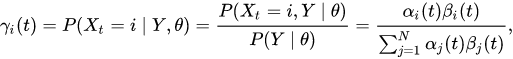
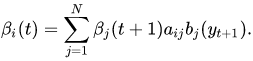
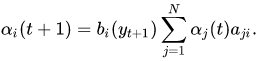
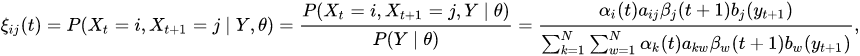

In [291]:
def baum_welch(A, B, 𝜋, y):
    N = A.shape[0]
    
    def calc_xi(𝛼, 𝛽, A, B, y, T):
        𝜉 = np.zeros((N, N, T))
        for i in range(N):
            for j in range(N):
                for t in range(T-1):
                   𝜉[i][j][t] =  𝛼[i][t] * A[i][j] * 𝛽[j][t+1]*B[j][y[t+1]]
                   𝜉[i][j][t] /= np.sum([np.sum([𝛼[k][t] * A[k][w] * 𝛽[w][t+1] * B[w][y[t+1]]  for w in range(N)]) for k in range(N)])
        return 𝜉

    def calc_gamma(𝛼, 𝛽, y, T):
        𝛾 = np.zeros((N, T))
        for i in range(N):
            for t in range(T):
                𝛾[i][t] = 𝛼[i][t] * 𝛽[i][t] / np.sum([𝛼[j][t] * 𝛽[j][t] for j in range(N)])
        return 𝛾
    
    # alpha-beta phase:
    def calc_alpha(A, B, y, T):
        𝛼 = np.zeros((N, T))
        for i in range(N):
            𝛼[i][0] = 𝜋[i] * B[i][y[0]]
        for i in range(N):
            for t in range(1, T):
                𝛼[i][t] = B[i][y[t]] * np.sum([𝛼[j][t-1] * A[j][i] for j in range(N)])
        return 𝛼

    def calc_beta(A, B, y, T):
        𝛽 = np.ones((N, T))
        for i in range(N):
            for t in range(T-2, -1, -1):
                for j in range(N):
                    𝛽[i][t] = np.sum([𝛽[j][t+1]*A[i][j]*B[j][y[t+1]] for j in range(N)])
        return 𝛽
    
    alpha = []
    beta = []
    gamma = []
    xi = []
    d = []
    for i in range(len(y) // 50):
        T = 50
        inp = y[i*50:(i+1)*50]
        d.append(inp)
        alpha.append(calc_alpha(A, B, inp, T))
        beta.append(calc_beta(A, B, inp, T))
        gamma.append(calc_gamma(alpha[-1], beta[-1], inp, T))
        #xi.append(calc_xi(𝛼, 𝛽, A, B, inp))
    # update pi
    d = np.array(d)
    gamma = np.array(gamma)
    𝜋[0] = np.sum(gamma[:, 0, 0]) / (len(y) // 50)
    𝜋[1] = np.sum(gamma[:, 1, 0]) / (len(y) // 50)
    # update A?
    # update B
    for i in range(N):
        s2 = np.sum([np.sum([gamma[r][i] for t in range(T)]) for r in range(0, len(y) // 50)])
        for vk in range(6):
            s1 = np.sum([np.sum([gamma[r][i] if d[r][t] == vk else 0 for t in range(T)]) for r in range(0, len(y) // 50)])
            B[i][vk] = np.sum(s1) / s2
    return B, 𝜋

In [292]:
baum_welch(A, Bi, initial_state, data)

(array([[0.12199333, 0.12527136, 0.16771239, 0.09713131, 0.16726973,
         0.32062188],
        [0.16238051, 0.15417443, 0.20367238, 0.09083028, 0.16180286,
         0.22713954]]),
 array([0.96637021, 0.03362979]))